This notebook uses `sktime`


Examples of classification; try just training a CNN versus Random Weights versus raw time series?
+ Justification: TimeNet paper suggests generic feature extractors exist


https://github.com/hfawaz/dl-4-tsc/tree/master/classifiers
https://pyts.readthedocs.io/en/stable/generated/pyts.datasets.load_basic_motions.html

In [40]:
import sys

import matplotlib.pyplot as plt
import json

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *


import degas as dg
dg.set_style()

# try:
#     from private.lyap import lyap_r, lyap_e, corr_dim
# except:
#     from nolds import lyap_r, lyap_e, corr_dim

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
all_scores = np.linspace(0, 1, 100)



np.savetxt("out.txt", list(all_scores))

In [53]:
NaN

NameError: name 'NaN' is not defined

In [8]:
%%bash

python sweep_surrogate_transfer_learning.py

Process is terminated.


In [64]:
dd = dict()

dd["yeller"] = 0
dd["tom"] = 1

ee = dict()

ee["ball"] = 1
ee["tom"] = 2

dd.update(dd)

In [65]:
dd

{'yeller': 0, 'tom': 1}

## Import experiment results

In [51]:
import json
from scipy.stats import sem 
semd = lambda x, **kwargs : 1.253 * sem(x, **kwargs)

with open("./results/transfer_learning.json", "r") as file:
    all_scores = json.load(file)
    
all_vals = list()
for key in all_scores:
    all_vals.append((all_scores[key]['score_tsfresh'], all_scores[key]['score_random'], all_scores[key]['score_transfer']))
all_vals = np.array(all_vals)

all_orderings = np.argsort(all_vals, axis=1)
all_orderings_keyed = ["".join([str(item) for item in item]) for item in all_orderings.tolist()]
np.unique(all_orderings_keyed, return_counts=True)

print(np.median(all_vals, axis=0))
print(semd(all_vals, axis=0))

[0.80838896 0.82       0.84423077]
[0.02719366 0.02787605 0.02405462]


In [52]:
print(np.median(all_vals[:, 2] - all_vals[:, 0]), semd(all_vals[:, 2] - all_vals[:, 0]))
print(np.median(all_vals[:, 2] - all_vals[:, 1]), semd(all_vals[:, 2] - all_vals[:, 1]))

0.02981221898968528 0.011938367751696799
0.018928198238543026 0.01009687782171268


In [25]:
attractor_list[[7, 4]]

TypeError: list indices must be integers or slices, not list

## Data scaling

<ipython-input-50-f3865886ca0f>:9: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  dev_vals = median_absolute_deviation(all_vals, axis=0, scale='normal')


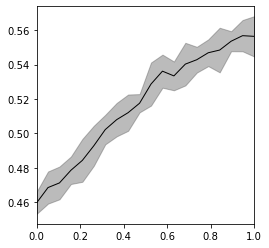

In [50]:
## plot results vs sota
from scipy.stats import sem, median_absolute_deviation

semd = lambda x, **kwargs : 1.2533 * sem(x, **kwargs)

all_vals = np.loadtxt('./results/sweep_surrogate_data.csv')

med_vals = np.median(all_vals, axis=0)
dev_vals = median_absolute_deviation(all_vals, axis=0, scale='normal')
# plt.plot(med_vals)
# plt.plot(med_vals + dev_vals)
# plt.plot(med_vals - dev_vals)
dg.plot_err(med_vals, dev_vals, x=np.linspace(0, 1, len(med_vals)))
plt.xlim([0, 1])


dg.fixed_aspect_ratio(1)


dg.better_savefig("../private_writing/fig_resources/data_scaling.png", dpi=600)

In [ ]:
#!/usr/bin/python3                                                                                                                                

import json
import pandas as pd
import numpy as np
import time

import pysindy as ps
from dsr import DeepSymbolicRegressor
from pysr import pysr, best_callable

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
metric_calc = lambda x0, x1 : mean_absolute_percentage_error(x0, x1, symmetric=True)

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
# from dysts.analysis import *                                                                                                                    
from dysts.analysis import sample_initial_conditions


cwd = os.path.dirname(os.path.realpath(__file__))
# cwd = "."                                                                                                                                       
# dataname = os.path.splitext(os.path.basename(os.path.split(input_path)[-1]))[0]                                                                 
output_path = cwd + "/results/symbolic_scores_sweep.json"

operator_list = [
            "cos",
            "exp",
            "sin",
            "log",
            "tanh",
            "inv(x) = 1/x",
        ]

NPROCS = 24
pysr_opts = {
    "populations" : 2 * NPROCS,
    "niterations" : 5,
#    "runtests" : False,                                                                                                                          
    "procs": NPROCS, # number of threads                                                                                                          
#    "procs": 0,                                                                                                                                  
    "delete_tempfiles" : True,
    "verbosity": 0,
    "unary_operators" : operator_list,
#    "multithreading" : True,                                                                                                                     
    "binary_operators" : ["+", "*"]
}

# get data                                                                                                                                        
with open(cwd + "/resources/symb_train_test_data.json", "r") as file:
    all_train_test = json.load(file)

try:
    with open(output_path, "r") as file:
        sym_scores = json.load(file)
except FileNotFoundError:
    sym_scores = dict()
    with open(output_path, 'w') as f:
        json.dump(sym_scores, f, indent=4)

for i, equation_name in enumerate(get_attractor_list()[100:]):

#    with open(output_path, "r") as file:                                                                                                         
#        sym_scores = json.load(file)                                                                                                             

    with open(output_path, "r") as file:
        sym_scores.update(json.load(file))

    if equation_name in sym_scores.keys():
        print(f"Entry for {equation_name} found, skipping it.", flush=True)
        continue
    print(equation_name, flush=True)


    sym_scores[equation_name] = dict()

    X_train = np.array(all_train_test[equation_name]["X_train"])
    y_train = np.array(all_train_test[equation_name]["y_train"])
    X_test = np.array(all_train_test[equation_name]["X_test"])
    y_test = np.array(all_train_test[equation_name]["y_test"])
    t_train = np.array(all_train_test[equation_name]["t_train"])
    t_test = np.array(all_train_test[equation_name]["t_test"])                                                                                                            

    ndim = min([X_test.shape[-1], y_test.shape[-1]])

    ## SINDY-poly                                                                                                                                 
    t0 = time.perf_counter()
    sym_model = ps.SINDy()
    sym_model.fit(X_train, t=t_train)
    y_test_pred = sym_model.predict(X_test)
    all_scores = list()
    for i in range(ndim):
        all_scores.append(metric_calc(y_test[:, i], y_test_pred[:, i]))
    sym_scores[equation_name]["SINDY-poly"] = np.median(all_scores)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    sym_scores[equation_name]["SINDY-poly-time"] = elapsed

    ## SINDY-fourier basis                                                                                                                        
    t0 = time.perf_counter()
    sym_model = ps.SINDy(feature_library=ps.FourierLibrary(n_frequencies=10))
    sym_model.fit(X_train, t=t_train)
    y_test_pred = sym_model.predict(X_test)
    all_scores = list()
    for i in range(ndim):
        all_scores.append(metric_calc(y_test[:, i], y_test_pred[:, i]))
    sym_scores[equation_name]["SINDY-fourier"] = np.median(all_scores)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    sym_scores[equation_name]["SINDY-fourier-time"] = elapsed

    ## DSR                                                                                                                                        
#    t0 = time.perf_counter()                                                                                                                     
#    all_scores = list()                                                                                                                          
#    for i in range(ndim):                                                                                                                        
#        model = DeepSymbolicRegressor(cwd + "/resources/config.json")                                                                            
#        model.fit(X_train, y_train[:, i])                                                                                                        
#        y_test_pred = model.predict(X_test)                                                                                                      
#        all_scores.append(metric_calc(y_test[:, i], y_test_pred))                                                                                
#        print("iter complete", flush=True)                                                                                                       
#    final_score = np.median(all_scores)                                                                                                          
#    sym_scores[equation_name]["DSR"] = final_score                                                                                               
#    t1 = time.perf_counter()                                                                                                                     
#    elapsed = t1 - t0                                                                                                                            
#    sym_scores[equation_name]["DSR-time"] = elapsed                                                                                              

    ## pySR                                                                                                                                        
    t0 = time.perf_counter()
    all_scores = list()
    for i in range(ndim):
        try:
            models = pysr(X_train, y_train[:, i], **pysr_opts)
            y_test_pred = best_callable(models)(X_test)
            all_scores.append(metric_calc(y_test[:, i], y_test_pred))
            print("iter complete", flush=True)
        except:
            print("bad iteration", flush=True)
    try:
        final_score = np.median(all_scores)
    except:
        final_score = None
    sym_scores[equation_name]["pySR"] = final_score
    t1 = time.perf_counter()
    elapsed = t1 - t0
    sym_scores[equation_name]["pySR-time"] = elapsed

    print(equation_name, final_score, flush=True)

    with open(output_path, "r") as file:
        sym_scores.update(json.load(file))

    sym_scores.update(curr_scores)

    with open(output_path, 'w') as f:
        json.dump(sym_scores, f, indent=4)

